# P2: ViT for Image Classification (30%)

### Quick intro: Vision Transformer (ViT) by Google Brain

The Vision Transformer (ViT) is basically BERT, but applied to images. It attains excellent results compared to state-of-the-art convolutional networks. In order to provide images to the model, each image is split into a sequence of fixed-size patches (typically of resolution 16x16 or 32x32), which are linearly embedded. One also adds a [CLS] token at the beginning of the sequence in order to classify images. Next, one adds absolute position embeddings and provides this sequence to the Transformer encoder.

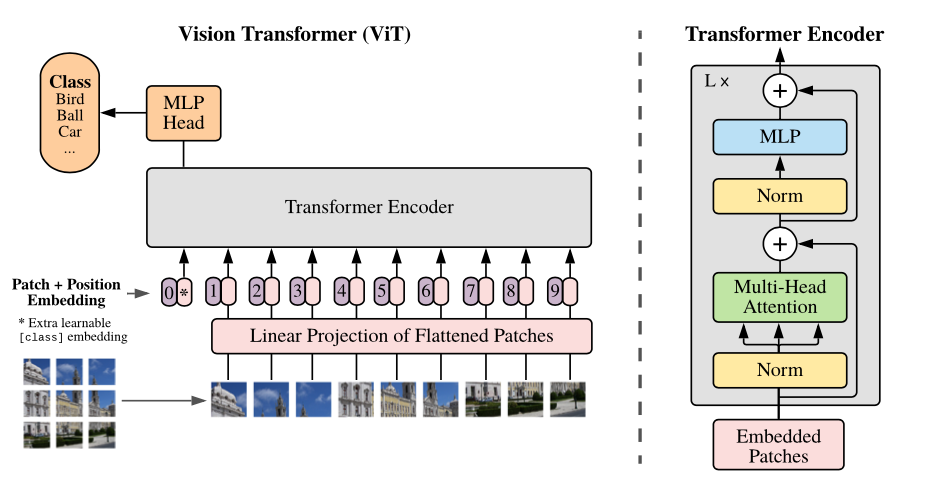

* Paper: https://arxiv.org/abs/2010.11929
* Official repo (in JAX): https://github.com/google-research/vision_transformer

### Performing Inference with the Vision Transformer for Image Classification

In [ ]:
!pip install 'transformers[torch]'

Let's start by installing the relevant libraries, and load the model from the hub, then move it to GPU.

In [ ]:
from transformers import ViTForImageClassification
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# NOTE: Here we are using a pretrained ViT-B model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.eval()
model.to(device)

Let's simply load in an image to let the ViT model perform inference on it.

In [ ]:
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)
im

In [ ]:
im.size

**Pre-Processing**: As mentioned in the paper, the model accepts an input resolution of `224x224`. The sample we have here is (640, 480). Here we use `ViTFeatureExtractor` to take care of `resizing` + `normalization`.

In [ ]:
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
# You can check out its implementation here: https://huggingface.co/transformers/_modules/transformers/models/vit/feature_extraction_vit.html#ViTFeatureExtractor
encoding = feature_extractor(images=im, return_tensors="pt")
encoding.keys()

In [ ]:
# Check the input after applying
encoding['pixel_values'].shape

**Forward Pass**: Let's send the image through the ViT model, which consists of a BERT-like encoder and a linear classification head on top of the last hidden state of the [CLS] token.

In [ ]:
im_input = encoding['pixel_values'].to(device)

# Feedforward
outputs = model(im_input)
logits = outputs.logits
logits.shape

In [ ]:
prediction = logits.argmax(-1)
print("Predicted class:", model.config.id2label[prediction.item()])

**Questions**:
1. Please find another image from the web (or you can upload them from local as well, any image that is good for classification is fine), and use the ViT-B model to get the predictions.


In [ ]:
# TODO: Please write your codes for Q1 here

2. As we know, pre-training a ViT model often requires lots of data and computation resources and that's why we use the pre-trained model weights provided by the official. Please visit the [HuggingFace model hub](https://huggingface.co/models?sort=downloads&search=google%2Fvit) for ViT model, and choose one to replace the `google/vit-base-patch16-224` in the following codes. Run the inference using the new pre-trained model checkpoints again and get the predictions.

(NOTE: Some of the pre-trained weights may be too large to fit for your GPU, choose the one that works.)

In [ ]:
# TODO: Please write your codes for Q2 here
# NOTE: Here we are using a ViT-B model on ImageNet 2012 (1 million images, 1,000 classes) at resolution 224x224, replace it with the one you choose from the model hub
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.eval()
model.to(device)

3. **Clearly** explain why the [CLS] logits have a shape of [1, 1000]. What if we train the model on CIFAR-10 from scratch, will this shape of logits change? (Yes/No), How? (The shape).



TODO: Please write your answers for Q3 here

4. What if I already had a trained model on ImageNet1k, in this case, a `vit-base-patch16-224` checkpoint , and now I have a new dataset, e.g., CIFAR-10, coming with multiple new classes. What do you think is the best strategy to adapt my existing models to the new datasets?

Here is the link [fine-tuning for transfer learning](https://cs231n.github.io/transfer-learning/) for your reference. You can read it first and then come back to answer this question.

### Fine-tune the Vision Transformer on CIFAR-10

In this section, we are going to fine-tune a pre-trained Vision Transformer on the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. This dataset is a collection of 60,000 32x32 colour images in 10 classes, with 6000 images per class, which we have been familiar with in the past homeworks.

We will prepare the data using [HuggingFace datasets](https://github.com/huggingface/datasets), and train the model using Pytorch.

<!-- [PyTorch Lightning ⚡](https://github.com/PyTorchLightning/pytorch-lightning).  -->



**Preprocessing the data**: Here we import a small portion of CIFAR-10, and prepare it for the model using `ViTFeatureExtractor`. This feature extractor will resize every image to the resolution that the model expects (let's use the default 224), and normalize the channels.

Note that in the ViT paper, the best results were obtained when fine-tuning at a higher resolution. For this, one interpolates the pre-trained absolute position embeddings.

In [ ]:
!pip install datasets

In [ ]:
from transformers import ViTFeatureExtractor

# NOTE: Here we are using a ViT-B model pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

In [ ]:
from datasets import load_dataset

# load cifar10 (only small portion for demonstration purposes)
train_ds, test_ds = load_dataset('cifar10', split=['train[:5000]', 'test[:2000]'])
# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

Thanks to HuggingFace Datasets' `.map(function, batched=True)` functionality, we can prepare images very fast (note that it still takes a few minutes on Google Colab).

In [ ]:
import numpy as np

def preprocess_images(examples):
    # get batch of images
    images = examples['img']
    # convert to list of NumPy arrays of shape (C, H, W)
    images = [np.array(image, dtype=np.uint8) for image in images]
    images = [np.moveaxis(image, source=-1, destination=0) for image in images]
    # preprocess and add pixel_values
    inputs = feature_extractor(images=images)
    examples['pixel_values'] = inputs['pixel_values']

    return examples

In [ ]:
from datasets import Features, ClassLabel, Array3D, Image

# we need to define the features ourselves as both the img and pixel_values have a 3D shape
features = Features({
    'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']),
    'img': Image(decode=True, id=None),
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
})

preprocessed_train_ds = train_ds.map(preprocess_images, batched=True, features=features)
preprocessed_val_ds = val_ds.map(preprocess_images, batched=True, features=features)
preprocessed_test_ds = test_ds.map(preprocess_images, batched=True, features=features)

**Define the model** The model itself uses a linear layer on top of a pre-trained `ViTModel`. We place a linear layer on top of the last hidden state of the [CLS] token, which serves as a good representation of an entire image. We also add dropout for regularization.

In [ ]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=10):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.num_labels = num_labels
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

To instantiate a `Trainer`, we will need to define three more things. The most important is the `TrainingArguments`, which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [ ]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-cifar-10",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    metric_for_best_model=metric_name,
    logging_dir='logs',
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, set the training and evaluation batch_sizes and customize the number of epochs for training, as well as the weight decay.

Then we will need a data collator that will batch our processed examples together, here the default one will work:

In [ ]:
from transformers import default_data_collator

data_collator = default_data_collator

In [ ]:
model = ViTForImageClassification()

We also define a `compute_metrics` function that will be used to compute metrics at evaluation. We use "accuracy", which is available in HuggingFace Datasets.


In [ ]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

Then we just need to pass all of this along with our datasets to the Trainer:

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=preprocessed_train_ds,
    eval_dataset=preprocessed_val_ds,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

**Train the model**: Let's first start up Tensorboard:

We can now finetune our model by just calling the `train` method:

In [ ]:
trainer.train()

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir logs/

**Evaluation**: Finally, let's evaluate the model on the test set:

In [ ]:
outputs = trainer.predict(preprocessed_test_ds)

print(outputs.metrics)

We can also easily create a confusion matrix using `sklearn`

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

**Questions**:
5. Fine-tune the model based on CIFAR-10 dataset using given `vit-base-patch16-224-in21k`, which is a ViT-B model pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x22, for 3 epochs with end-to-end setting (it might take ~20 mins on Colab). Report the accuracy on the test set, show the whole tensorboard training logs and the confusion matrix from sklearn.



6. Fine-tune the model based on CIFAR-10 dataset using `vit-base-patch16-224-in21k`, which is a ViT-B model pre-trained on ImageNet-21k, for 3 epochs with backbone (encoder) fixed setting (see [torch.no_grad()](https://pytorch.org/docs/stable/generated/torch.no_grad.html) for details). Please also report the accuracy on the test set, show the whole tensorboard training logs and the confusion matrix from sklearn.


7. Think about the difference between these two settings (end-to-end vs. backbone (encoder) fixed). Why we need the second settings, especially when we are facing even larger models (e.g., ViT-L `vit-large-patch16-384-in21k`)?


In [ ]:
# TODO: Q5 and Q6